# Multi-Modal Ligand-Receptor Inference

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import liana as li
import mudata as mu

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## Infer Ligand-Receptor Interactions between RNA and Proteins

### Download Processed CITE-seq Data

In [2]:
prot = sc.read('citeseq_prot.h5ad', backup_url='https://figshare.com/ndownloader/files/47625196')
rna = sc.read('citeseq_rna.h5ad', backup_url='https://figshare.com/ndownloader/files/47625193')

### Load Processed CITE-Seq Data

Here, we will use a very simple dataset to demonstrate the multi-modal ligand-receptor inference. We used a [CITE-Seq dataset from 10X](https://support.10xgenomics.com/single-cell-gene-expression/datasets/3.0.2/5k_pbmc_protein_v3) and followed the [muon CITE-seq tutorial](https://muon-tutorials.readthedocs.io/en/latest/cite-seq/1-CITE-seq-PBMC-5k.html) to process the RNA and Protein data. 

Some minor differences are notable in the clustering due to the different versions of the packages used in the tutorial and the LIANA+ environment.

In [3]:
mdata = mu.MuData({'rna': rna, 'prot': prot})
# make sure that cell type is accessible
mdata.obs['celltype'] = mdata.mod['rna'].obs['celltype'].astype('category')
# inspect the object
mdata

MuData object with n_obs × n_vars = 3885 × 17838
  obs:	'celltype'
  var:	'gene_ids', 'feature_types', 'genome'
  2 modalities
    rna:	3885 x 17806
      obs:	'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'celltype'
      var:	'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
      obsm:	'X_pca', 'X_umap'
      obsp:	'connectivities', 'distances'
    prot:	3885 x 32
      var:	'gene_ids', 'feature_types', 'genome'
      uns:	'neighbors', 'pca', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'counts'
      obsp:	'connectivities', 'distances'

### Infer Interactions

We see that we have two modalities, once for RNA and one for Proteins. We will next infer the ligand-receptor interactions between these two modalities. 

CITE-seq data often focuses on antibody tagging of surface proteins, primarily receptors. To ensure only the protein modality is used for receptors, we append `'AB:'` to receptor names in the antibody data. This step is necessary only when both RNA and antibody data have matching feature names.

In [4]:
# Obtain a ligand-receptor resource of interest
resource = li.rs.select_resource(resource_name='consensus')
# Append AB: to the receptor names
resource['receptor'] = 'AB:' + resource['receptor']

# Append AB: to the protein modality
mdata.mod['prot'].var_names = 'AB:' + mdata.mod['prot'].var['gene_ids']

While running LIANA+ with multimodal is largely analogous to when working with uni-modal data, there are a couple of things to keep in mind. Here, we need to ensure that the correct data is passed from each modality as well as to ensure that the correct modalities are used. Moreover, we need to ensure that data from the different modalities is comparable, which often requires the transformation of the data.

In this case, we use **zero-inflated min-max** normalization to ensure that the data from the two modalities is comparable. Essentially, a min-max normalization in which any value bellow 0.5 (by default) following normalization is set to 0. This normalization was originally introduced by the [CiteFuse method](https://academic.oup.com/bioinformatics/article/36/14/4137/5827474?login=false), which is a ligand-receptor method for CITE-seq data.

In [5]:
li.mt.rank_aggregate(adata=mdata,
                     groupby='celltype',
                     # pass our modified resource
                     resource=resource,
                     # NOTE: Essential arguments when handling multimodal data
                     mdata_kwargs={
                     # Ligand-Receptor pairs are directed so we need to correctly pass
                     # `RNA` with ligands as `x_mod` and receptors as `y_mod`
                     'x_mod': 'rna',
                     'y_mod': 'prot',
                     # We use .X from the x_mod
                     'x_use_raw':False,
                     # We use .X from the y_mod
                     'y_use_raw':False,
                     # NOTE: we need to ensure that the modalities are correctly transformed
                     'x_transform':li.ut.zi_minmax,
                     'y_transform':li.ut.zi_minmax,
                    },
                  verbose=True
                  )


Using `.X`!


Using provided `resource`.
Transforming rna using zi_minmax


Using `.X`!
Converting to sparse csr matrix!
Using `.X`!
46 features of mat are empty, they will be removed.
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/liana/method/_pipe_utils/_pre.py:150: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


Transforming prot using zi_minmax


0.69 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 3885 samples and 37 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB


100%|██████████| 1000/1000 [00:04<00:00, 229.48it/s]


Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


In [6]:
mdata.uns['liana_res'].head()

,source,target,ligand_complex,receptor_complex,lr_means,cellphone_pvals,expr_prod,scaled_weight,lr_logfc,spec_weight,lrscore,specificity_rank,magnitude_rank
335,pre-B,CD4+ memory T,HLA-DRA,AB:CD4,0.775442,0.0,0.600403,1.294984,0.643030,0.054068,0.968058,0.003006,0.000006
305,mature B,CD4+ memory T,HLA-DRA,AB:CD4,0.772048,0.0,0.594934,1.284592,0.640910,0.053575,0.967917,0.003511,0.000022
450,pre-B,CD4+ naïve T,HLA-DRA,AB:CD4,0.756579,0.0,0.572285,1.246018,0.640179,0.051536,0.967308,0.003890,0.000050
420,mature B,CD4+ naïve T,HLA-DRA,AB:CD4,0.753185,0.0,0.567072,1.235627,0.638059,0.051066,0.967163,0.003890,0.000089
324,pDC,CD4+ memory T,HLA-DRA,AB:CD4,0.751015,0.0,0.561047,1.220208,0.594210,0.050524,0.966993,0.003890,0.000138


<div class="alert alert-block alert-info">

Note that feature-wise min-max binds all features (i.e. genes and proteins) to the same limits, which essentially neglects the biological differences between features. This is typically not the case when working with untransformed data, as in that case we mostly care about cells being comparable, while features are typically with variable limits / distributions. As such, there might be some subtle differences from the interpretation of LIANA+ results, depending on the transformation of choice.

A benchmark of different normalizations for CCC are pending and alternative normalizations should also be explored. While other normalizations and subsequent transformations can also be used, the single-cell methods in LIANA+ require the data to be non-negative.

</div>

### Plot Results & More

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


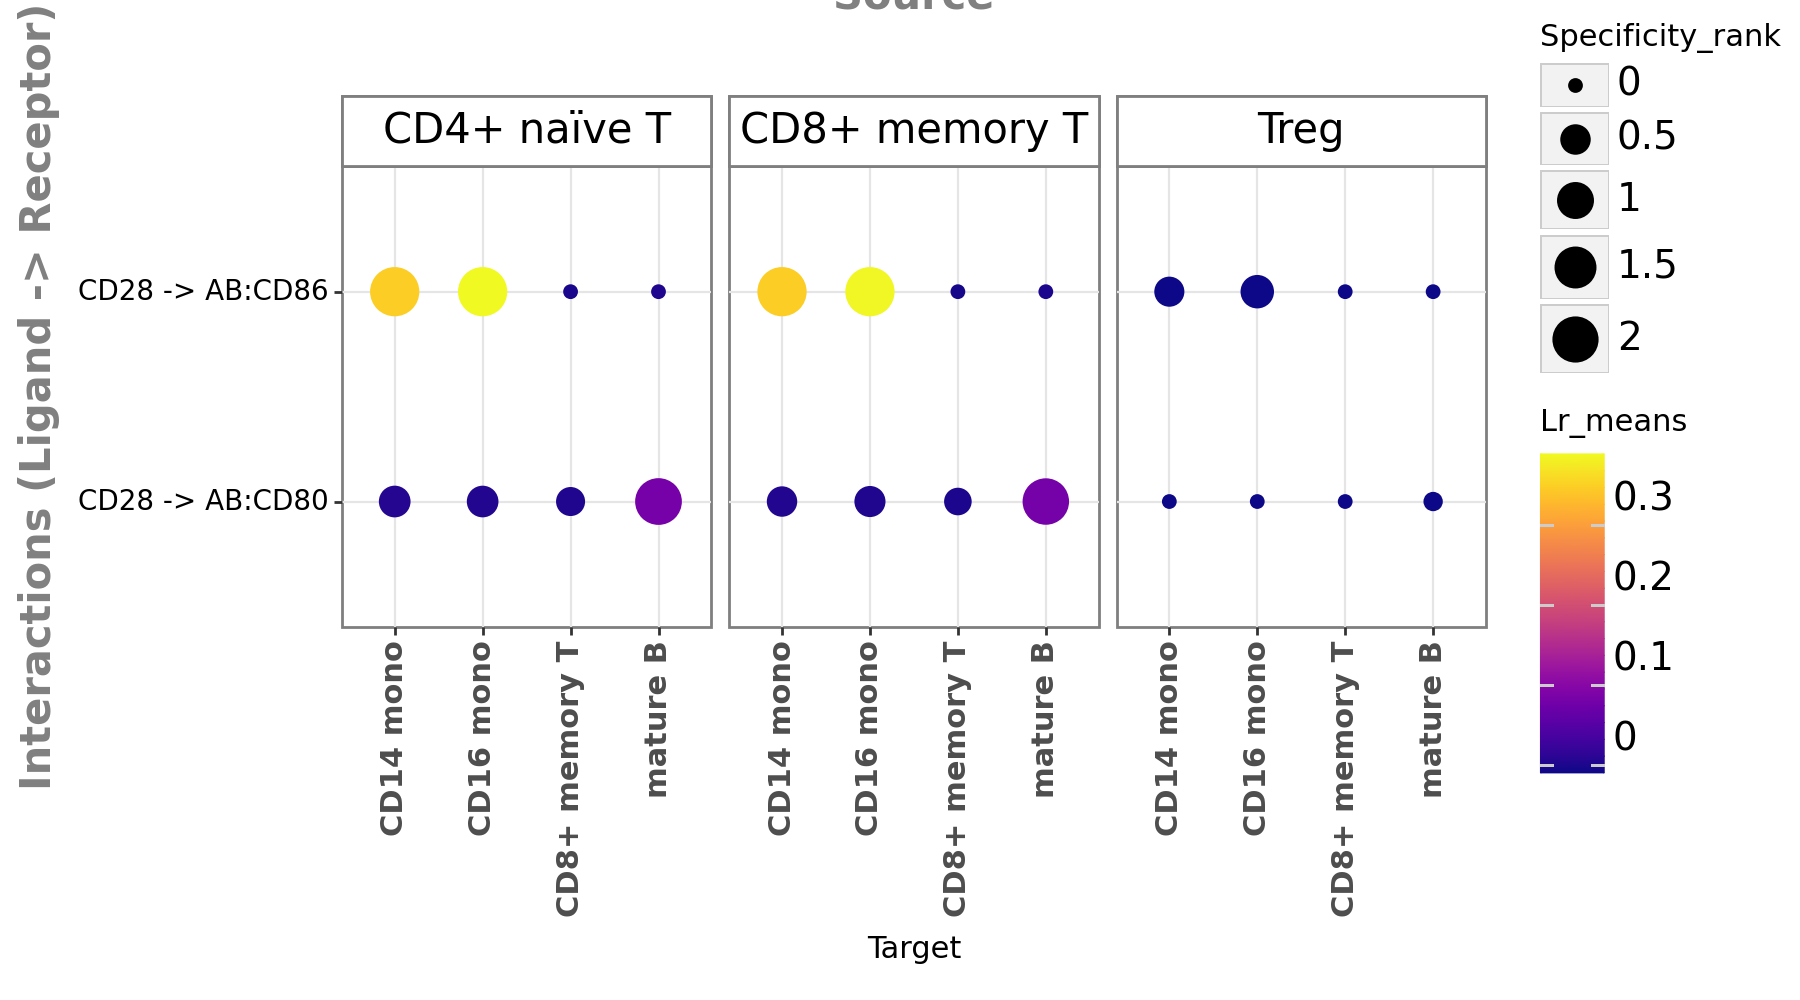

<Figure Size: (900 x 500)>

In [7]:
li.pl.dotplot(adata = mdata,
              colour='lr_means',
              size='specificity_rank',
              inverse_size=True, # we inverse sign since we want small p-values to have large sizes
              source_labels=['CD4+ naïve T', 'NK', 'Treg', 'CD8+ memory T'],
              target_labels=['CD14 mono', 'mature B', 'CD8+ memory T', 'CD16 mono'],
              figure_size=(9, 5),
              # finally, since cpdbv2 suggests using a filter to FPs
              # we filter the pvals column to <= 0.05
              filter_fun=lambda x: x['cellphone_pvals'] <= 0.05,
              cmap='plasma'
             )

## Metabolite-mediated CCC from Transcriptomics Data

Recently, tools such as NeuronChat, scConnect, Cellinker, and CellPhoneDBv5 have proposed simple methods, such as enrichment, expression average, among others, to infer metabolite-mediated CCC events from transcriptomics data. Similarly, we can use LIANA+ to infer metabolite-mediated CCC events from transcriptomics data, as [described in the MetalinksDB manuscript](https://www.biorxiv.org/content/10.1101/2023.12.30.573715v1.abstract).

Briefly, we use a univariate linear regression model to estimate metabolite abundances for each cell. To do so, we make use of production-degradation enzyme prior knowledge to infer the metabolite abundances. Optionally, we also take transporters into account. We then use these inferred metabolite abundances to infer metabolite-mediated CCC events.

<img src="../_static/metalinks_score.png" width=1000 />

### Focus on Transcriptomics Data

In [8]:
adata = mdata.mod['rna']

### Obtain MetalinksDB Prior Knowledge

Here, we will use MetalinksDB which contains prior knowledge about metabolite-receptor interactions as well as such for the production and degradation enzymes for metabolites. We will use the latter type of prior knowledge to infer the metabolite abundances for each cell.

In [9]:
metalinks = li.resource.get_metalinks(biospecimen_location='Blood',
                                      source=['CellPhoneDB', 'Cellinker', 'scConnect', # Ligand-Receptor resources
                                              'recon', 'hmr', 'rhea', 'hmdb' # Production-Degradation resources
                                              ],
                                      types=['pd', 'lr'], # NOTE: we obtain both ligand-receptor and production-degradation sets
                                     )

Database downloaded and saved to /mnt/97efc476-fe88-4281-aa1a-cf9a249ca294/liana-py/docs/source/notebooks/metalinksdb.db.


### Prepare the Metabolite-Receptor Resource

In [10]:
resource = metalinks[metalinks['type']=='lr'].copy()
resource = resource[['metabolite', 'gene_symbol']]\
    .rename(columns={'gene_symbol':'receptor'}).drop_duplicates()
resource.head()

,metabolite,receptor
173,Oxoglutaric acid,OXGR1
351,Acetaldehyde,TRPA1
410,Calcitriol,VDR
843,ADP,P2RY1
1071,ADP,P2RY6


### Prepare the Production-Degradation Network

In [11]:
pd_net = metalinks[metalinks['type'] == 'pd']
# we need to aggregate the production-degradation values
pd_net = pd_net[['metabolite', 'gene_symbol', 'mor']].groupby(['metabolite', 'gene_symbol']).agg('mean').reset_index()
pd_net.head()

,metabolite,gene_symbol,mor
0,(+)-Limonene,CYP2C19,-1.0
1,(+)-Limonene,CYP2C9,-1.0
2,(R)-Lipoic acid,CEL,1.0
3,(R)-Lipoic acid,DLD,-1.0
4,(R)-Lipoic acid,LIPA,1.0


### Prepare the transporter network

In [12]:
t_net = metalinks[metalinks['type'] == 'pd']
t_net = t_net[['metabolite', 'gene_symbol', 'transport_direction']].dropna()
# Note that we treat export as positive and import as negative
t_net['mor'] = t_net['transport_direction'].apply(lambda x: 1 if x == 'out' else -1 if x == 'in' else None)
t_net = t_net[['metabolite', 'gene_symbol', 'mor']].dropna().groupby(['metabolite', 'gene_symbol']).agg('mean').reset_index()
t_net = t_net[t_net['mor']!=0]

In [14]:
meta = li.mt.fun.estimate_metalinks(adata,
                                    resource,
                                    pd_net=pd_net,
                                    t_net=t_net, # (Optional)
                                    use_raw=False, 
                                    # keyword arguments passed to decoupler-py
                                    source='metabolite', target='gene_symbol',
                                    weight='mor', min_n=3)
# pass cell type information
meta.obs['celltype'] = adata.obs['celltype']

Essentially, we now have a dataset with two modalities, one for RNA and one for Metabolites. The metabolites are estimated as t-values. Let's visualize a couple:

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


<Figure size 2183.4x480 with 0 Axes>

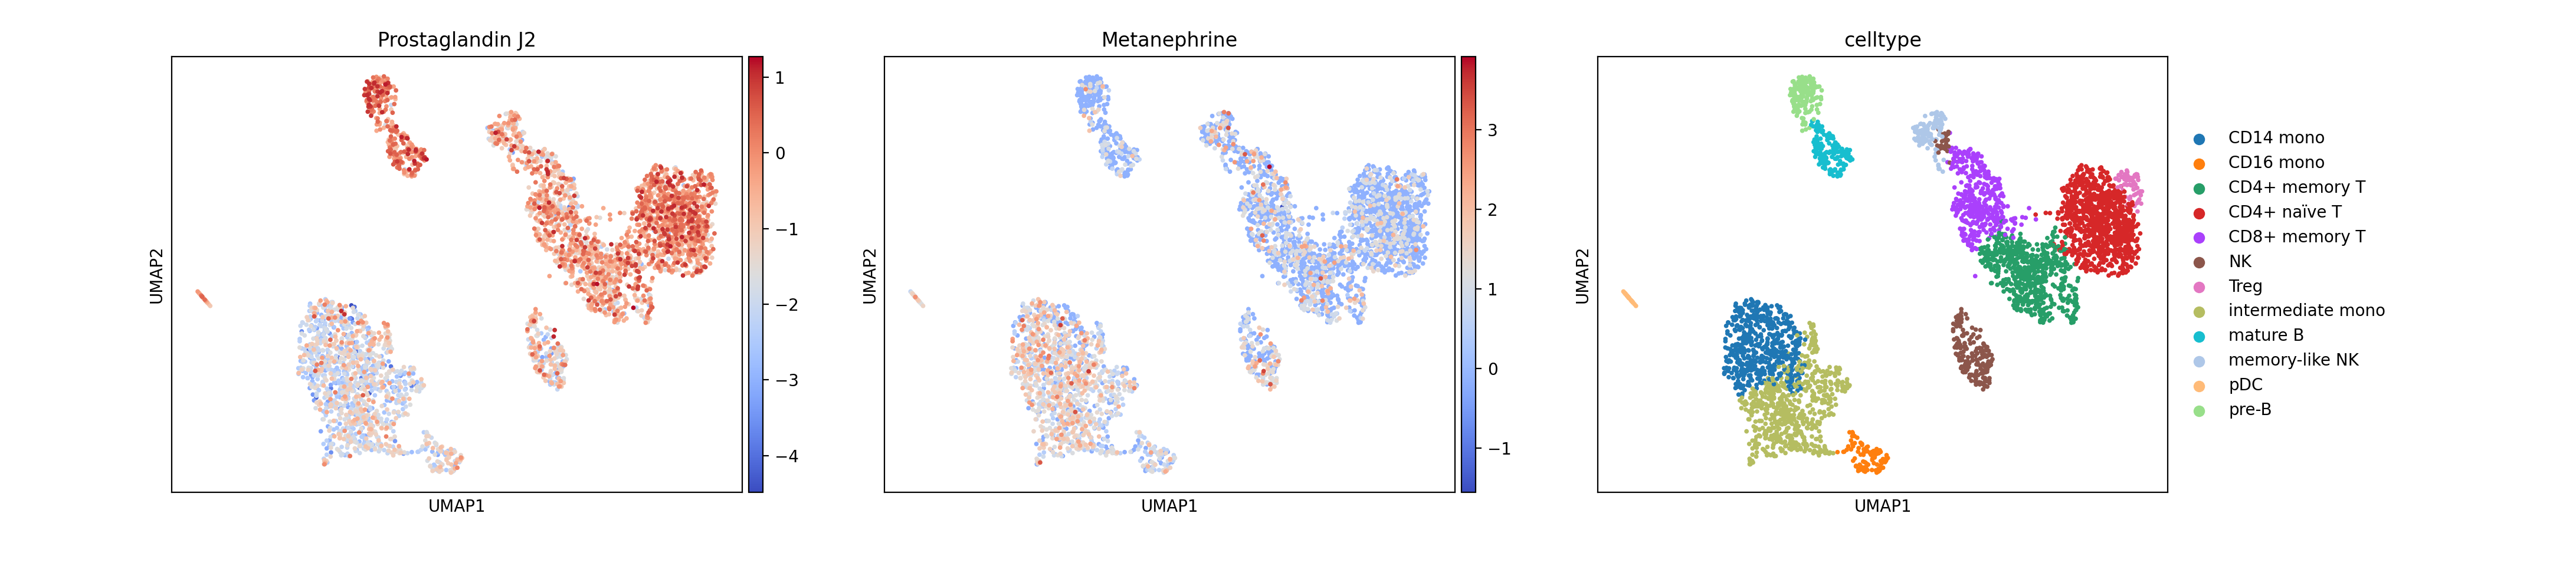

In [20]:
sc.pl.umap(meta.mod['metabolite'], color=['Prostaglandin J2', 'Metanephrine', 'celltype'], cmap='coolwarm')

### Infer Metabolite-Receptor Interactions

We will next infer the putative ligand-receptor interactions between these two modalities.

In [16]:
li.mt.rank_aggregate(adata=meta,
                     groupby='celltype',
                     # pass our modified resource
                     resource=resource.rename(columns={'metabolite':'ligand'}),
                     # NOTE: Essential arguments when handling multimodal data
                     mdata_kwargs={
                     'x_mod': 'metabolite',
                     'y_mod': 'receptor',
                     'x_use_raw':False,
                     'y_use_raw':False,
                     'x_transform':li.ut.zi_minmax,
                     'y_transform':li.ut.zi_minmax,
                    },
                  verbose=True
                  )


Using `.X`!
Converting to sparse csr matrix!


Using provided `resource`.
Transforming metabolite using zi_minmax


Using `.X`!
Using `.X`!
9 features of mat are empty, they will be removed.
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/liana/method/_pipe_utils/_pre.py:150: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
0.42 of entities in the resource are missing from the data.


Transforming receptor using zi_minmax
Generating ligand-receptor stats for 3885 samples and 190 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB


100%|██████████| 1000/1000 [00:06<00:00, 154.75it/s]


Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


### Explore Results

In [17]:
meta.uns['liana_res'].head()

,source,target,ligand_complex,receptor_complex,lr_means,cellphone_pvals,expr_prod,scaled_weight,lr_logfc,spec_weight,lrscore,specificity_rank,magnitude_rank
1921,pre-B,NK,Prostaglandin J2,PTGDR,0.498391,0.0,0.170128,1.251592,0.361967,0.069165,0.736382,0.001834,7.902015e-07
1845,mature B,NK,Prostaglandin J2,PTGDR,0.482969,0.0,0.163384,1.204874,0.341928,0.066424,0.732437,0.002293,3.160181e-06
1793,Treg,NK,Prostaglandin J2,PTGDR,0.472940,0.0,0.158999,1.174495,0.321561,0.064641,0.729763,0.002528,7.109003e-06
1713,CD4+ naïve T,NK,Prostaglandin J2,PTGDR,0.461330,0.0,0.153923,1.139323,0.345938,0.062577,0.726551,0.002954,1.263573e-05
1687,CD4+ memory T,NK,Prostaglandin J2,PTGDR,0.416394,0.0,0.134274,1.003199,0.259653,0.054589,0.712777,0.003029,5.050294e-05


/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/liana/plotting/_common.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


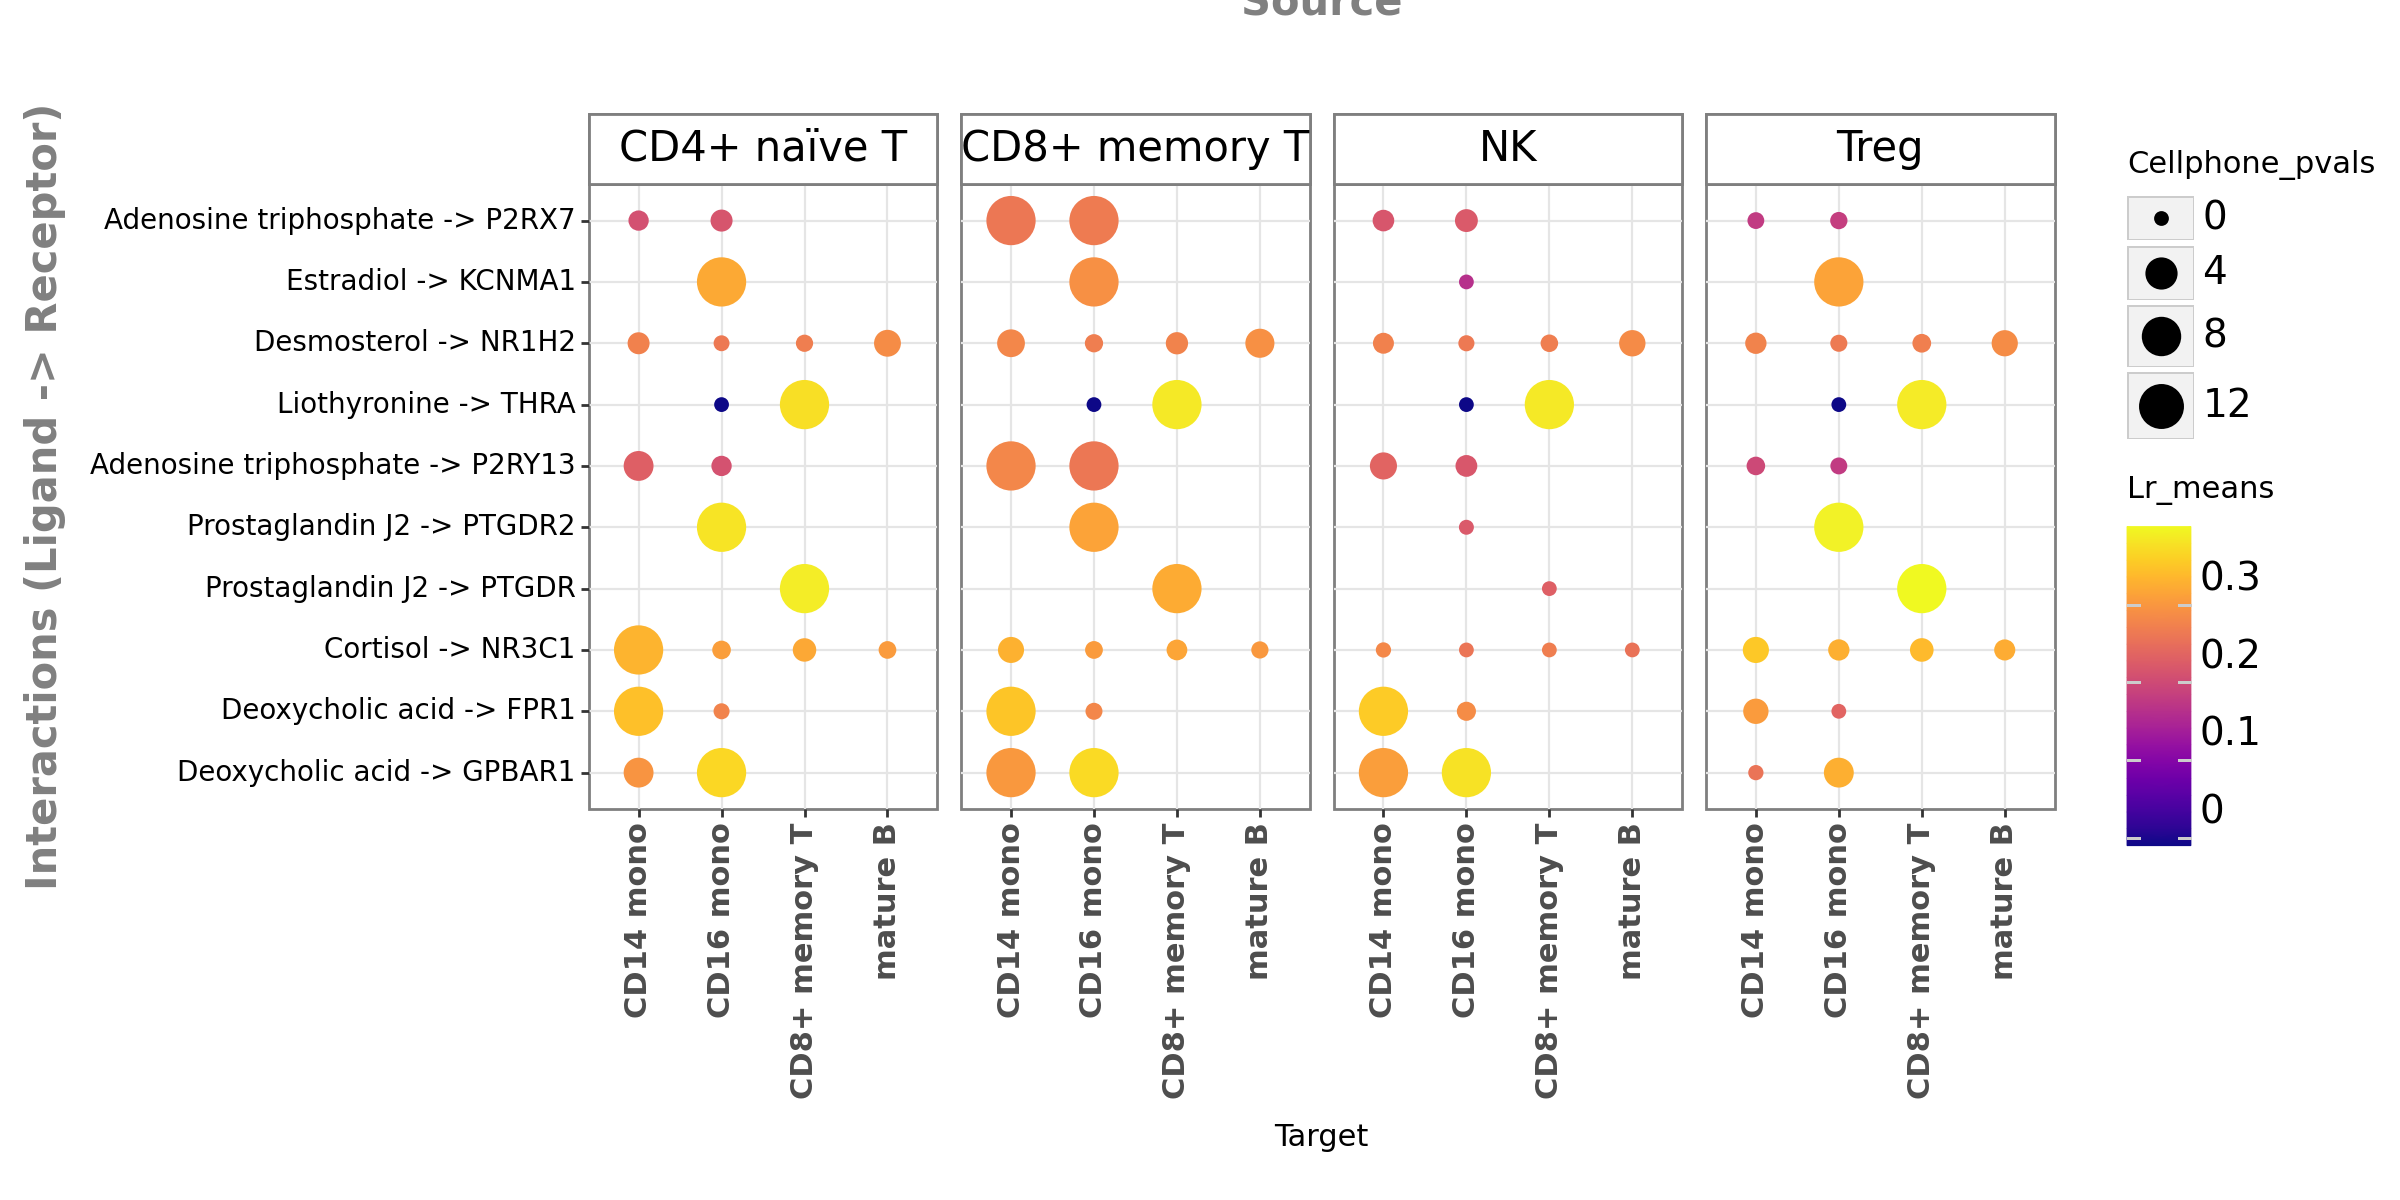

<Figure Size: (1200 x 600)>

In [18]:
li.pl.dotplot(adata = meta,
              colour='lr_means',
              size='cellphone_pvals',
              inverse_size=True, # we inverse sign since we want small p-values to have large sizes
              source_labels=['CD4+ naïve T', 'NK', 'Treg', 'CD8+ memory T'],
              target_labels=['CD14 mono', 'mature B', 'CD8+ memory T', 'CD16 mono'],
              figure_size=(12, 6),
              # Filter to top 10 acc to magnitude rank
              top_n=10,
              orderby='magnitude_rank',
              orderby_ascending=True,
              cmap='plasma'
             )

<div class="alert alert-warning">

Our inferred metabolite-protein interactions remain purely hypothetical and require validation.

Our metabolite estimation approach, like other approaches predicting metabolite-receptor interactions from transcriptomics data, infers metabolite abundances from gene expression, assuming a linear relationship. This also assumes enzymatic gene expression proxies metabolite abundance, overlooking the complex, non-linear nature of metabolite fluxes influenced by cell states and microenvironments. Finally, our method treats each metabolite independently, a simplification that [more sophisticated methods](https://www.sciencedirect.com/science/article/pii/S2212877821002532) or [multi-omics integration](https://liana-py.readthedocs.io/en/latest/notebooks/sma.html) may address.

</div>

## Next Steps
From here on one may follow-up with any of the other LIANA+ functionalities, such as plotting the results, or cross-conditional analyses.